## What percentage of developers are satisfied with their job?
I have used machine learning to analyze which factors have influenced the outcome of the Stack Overflow Survey for 2020.

### import module

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn import datasets
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
%matplotlib inline

import optuna.integration.lightgbm as lgb

### Read csv data and confirm the data

In [2]:
# Read Stack Overflow survey 2020 data
df = pd.read_csv('./developer_survey_2020/survey_results_public.csv')
print(df.shape)
df.head()

(64461, 61)


,Respondent,MainBranch,Hobbyist,Age,Age1stCode,CompFreq,CompTotal,ConvertedComp,Country,CurrencyDesc,...,SurveyEase,SurveyLength,Trans,UndergradMajor,WebframeDesireNextYear,WebframeWorkedWith,WelcomeChange,WorkWeekHrs,YearsCode,YearsCodePro
0,1,I am a developer by profession,Yes,NaN,13,Monthly,NaN,NaN,Germany,European Euro,...,Neither easy nor difficult,Appropriate in length,No,"Computer science, computer engineering, or sof...",ASP.NET Core,ASP.NET;ASP.NET Core,Just as welcome now as I felt last year,50.0,36,27
1,2,I am a developer by profession,No,NaN,19,NaN,NaN,NaN,United Kingdom,Pound sterling,...,NaN,NaN,NaN,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat more welcome now than last year,NaN,7,4
2,3,I code primarily as a hobby,Yes,NaN,15,NaN,NaN,NaN,Russian Federation,NaN,...,Neither easy nor difficult,Appropriate in length,NaN,NaN,NaN,NaN,Somewhat more welcome now than last year,NaN,4,NaN
3,4,I am a developer by profession,Yes,25.0,18,NaN,NaN,NaN,Albania,Albanian lek,...,NaN,NaN,No,"Computer science, computer engineering, or sof...",NaN,NaN,Somewhat less welcome now than last year,40.0,7,4
4,5,"I used to be a developer by profession, but no...",Yes,31.0,16,NaN,NaN,NaN,United States,NaN,...,Easy,Too short,No,"Computer science, computer engineering, or sof...",Django;Ruby on Rails,Ruby on Rails,Just as welcome now as I felt last year,NaN,15,8


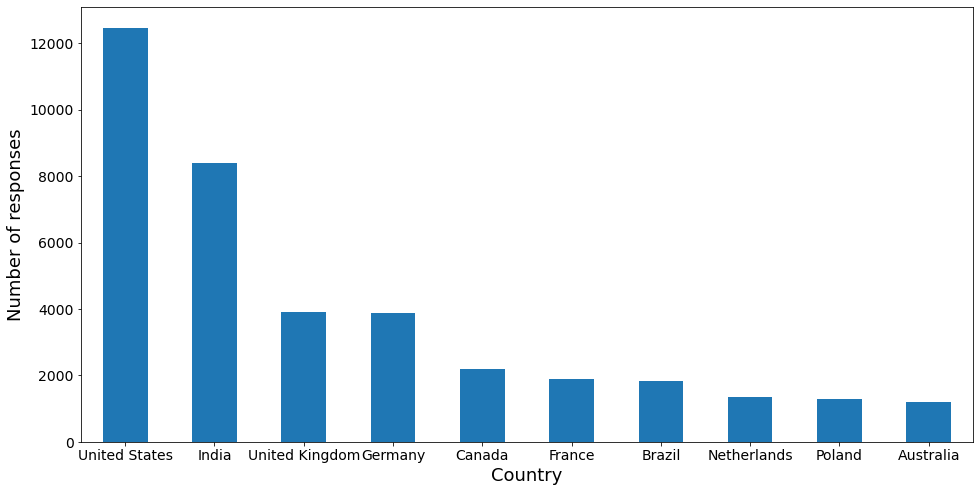

In [3]:
#Number of responses by country
df_country = df["Country"].value_counts()[:10]
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(16, 8));
df_country.plot.bar(ax=ax);
ax.set_ylabel("Number of responses", fontdict={'size':18});
ax.set_xticklabels(ax.get_xticklabels(), rotation=0);
ax.set_xlabel("Country", fontdict={'size': 18});
ax.tick_params(axis='both', labelsize=14);

In [5]:
#Percentage of responses from Japan
df_country_persentage = df["Country"].value_counts(normalize=True)
df_country_persentage['Japan']

0.004635410163565988

### Make pie chart to find what percentage of developers are satisfied with their job.

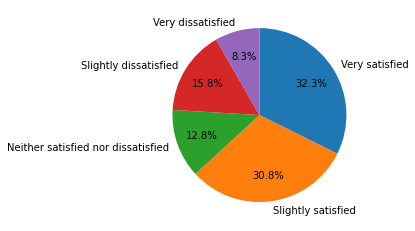

In [3]:
# function to make pie chart
def make_pie_chart(df):
    '''
    INPUT
    df - pandas dataframe
    
    OUTPUT
    pie chart
    '''
    table = { key: (df['JobSat']==key).sum() for key in set(df['JobSat'])} 
    values = [table["Very satisfied"], table["Slightly satisfied"], table["Neither satisfied nor dissatisfied"], table["Slightly dissatisfied"], table["Very dissatisfied"]]
    label = ["Very satisfied", "Slightly satisfied", "Neither satisfied nor dissatisfied", "Slightly dissatisfied", "Very dissatisfied"]
    plt.pie(values,
           labels=label, counterclock=False, startangle=90,
           autopct='%1.1f%%', pctdistance=0.7)
    plt.savefig("pie_chart.jpg")
    plt.show()
    
make_pie_chart(df)

### Data preprocessing for LightGBM

In [4]:
def clean_data(df):
    '''
    INPUT
    df - pandas dataframe 
    
    OUTPUT
    X - A matrix holding all of the variables you want to consider when predicting the response
    y - the corresponding response vector
    
    This function cleans df using the following steps to produce X and y:
    1. Drop all the rows with no 'JobSat'
    2. Create y as the 'JobSat' column
    3. Change 'JobSat' data from string to value (LabelEncoder)
    4. For each numeric variable in df, fill the column with the mean value of the column.
    5. Create dummy columns for all the categorical variables in df, drop the original columns
    6.Create X as all the columns that are not the 'JobSat' and ' Respondent' column
    '''
    le = LabelEncoder()    
    
    # Drop rows with missing 'JobSat'
    df = df.dropna(subset=['JobSat'], axis=0)
    
    #Create y as the'JobSat' column
    df_JobSat = df['JobSat']
    
    #LabelEncoder
    le.fit(df_JobSat)
    y = le.transform(df_JobSat)
    
    # Fill numeric columns with the mean
    num_vars = df.select_dtypes(include=['float', 'int']).columns
    for col in num_vars:
        df[col].fillna((df[col].mean()), inplace=True)
    
    le = LabelEncoder()
    # The categorical variables to the label
    cat_vars = df.select_dtypes(include=['object']).copy().columns
    for var in  cat_vars:
        #LabelEncoder
        le.fit(df[var])
        df[var] = le.transform(df[var])
    
    X = df.drop(['JobSat', 'Respondent'], axis=1)
    return X, y
    
#Use the function to create X and y
X, y = clean_data(df) 

C:\Users\10349\anaconda3\envs\avilen\lib\site-packages\pandas\core\series.py:4523: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  downcast=downcast,
C:\Users\10349\anaconda3\envs\avilen\lib\site-packages\ipykernel\__main__.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [5]:
# split data to train and test
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.30, random_state=2)

### Fit model

In [6]:
# set the data to fit model
lgb_train = lgb.Dataset(X_train, y_train)
lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train) 

# LightGBM parameters
params = {
        'task': 'train',
        'boosting_type': 'gbdt',
        'objective': 'multiclass', 
        'num_class': 5,           
        'metric': 'multi_logloss', 
        'max_depth' : 10,
}

evaluation_results = {}      
# make model
model = lgb.train(params,
                  num_boost_round=10,
                  train_set=lgb_train, 
                  valid_sets=[lgb_train, lgb_eval], 
                  evals_result=evaluation_results,
                  early_stopping_rounds=20,
                  valid_names=['train', 'valid'],        
                  )


# predict by test data
y_pred = model.predict(X_test, num_iteration=model.best_iteration)
y_pred_max = np.argmax(y_pred, axis=1)

# calcurate accuracy
accuracy = sum(y_test == y_pred_max) / len(y_test)
print('accuracy:', accuracy)
    
optimum_boost_rounds = model.best_iteration

[I 2021-03-23 23:24:21,319] A new study created in memory with name: no-name-8c7de336-a4ce-4379-86ba-5dfa3fb2808f
feature_fraction, val_score: inf:   0%|                                                                                | 0/7 [00:00<?, ?it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006353 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start tr

feature_fraction, val_score: 1.383802:  14%|#########5                                                         | 1/7 [00:00<00:02,  2.15it/s]

[9]	train's multi_logloss: 1.35708	valid's multi_logloss: 1.38902
[10]	train's multi_logloss: 1.34867	valid's multi_logloss: 1.3838
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.34867	valid's multi_logloss: 1.3838
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011004 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set

feature_fraction, val_score: 1.383802:  29%|###################1                                               | 2/7 [00:01<00:02,  1.81it/s]


[10]	train's multi_logloss: 1.35889	valid's multi_logloss: 1.39178
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.35889	valid's multi_logloss: 1.39178
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.018810 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Ligh

feature_fraction, val_score: 1.376345:  43%|############################7                                      | 3/7 [00:01<00:02,  1.73it/s]

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011676 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start tr

feature_fraction, val_score: 1.372837:  57%|######################################2                            | 4/7 [00:02<00:01,  1.68it/s]

[6]	train's multi_logloss: 1.3731	valid's multi_logloss: 1.39608
[7]	train's multi_logloss: 1.36311	valid's multi_logloss: 1.38992
[8]	train's multi_logloss: 1.35251	valid's multi_logloss: 1.38252
[9]	train's multi_logloss: 1.34295	valid's multi_logloss: 1.37642
[10]	train's multi_logloss: 1.3357	valid's multi_logloss: 1.37284
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.3357	valid's multi_logloss: 1.37284
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011287 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[Ligh

feature_fraction, val_score: 1.368860:  71%|###############################################8                   | 5/7 [00:02<00:01,  1.60it/s]

[10]	train's multi_logloss: 1.33119	valid's multi_logloss: 1.36886
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.33119	valid's multi_logloss: 1.36886
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Light

feature_fraction, val_score: 1.368860:  86%|#########################################################4         | 6/7 [00:03<00:00,  1.61it/s]

[10]	train's multi_logloss: 1.33227	valid's multi_logloss: 1.37042
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.33227	valid's multi_logloss: 1.37042
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011525 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[Light

feature_fraction, val_score: 1.368860:  86%|#########################################################4         | 6/7 [00:04<00:00,  1.61it/s]

[3]	train's multi_logloss: 1.4247	valid's multi_logloss: 1.43527
[4]	train's multi_logloss: 1.40996	valid's multi_logloss: 1.4246
[5]	train's multi_logloss: 1.39481	valid's multi_logloss: 1.41294
[6]	train's multi_logloss: 1.38186	valid's multi_logloss: 1.40396
[7]	train's multi_logloss: 1.37179	valid's multi_logloss: 1.3975
[8]	train's multi_logloss: 1.3595	valid's multi_logloss: 1.38918
[9]	train's multi_logloss: 1.35211	valid's multi_logloss: 1.38535
[10]	train's multi_logloss: 1.34419	valid's multi_logloss: 1.38052
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.34419	valid's multi_logloss: 1.38052


num_leaves, val_score: 1.368860:   0%|                                                                                | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009570 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's multi_logloss: 1.42683	valid's multi_logloss: 1.458

num_leaves, val_score: 1.368860:   5%|###6                                                                    | 1/20 [00:01<00:26,  1.37s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011363 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's multi_logloss: 1.42683	valid's multi_logloss: 1.458

num_leaves, val_score: 1.368860:  10%|#######2                                                                | 2/20 [00:02<00:25,  1.44s/it]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	train's multi_logloss: 1.10886	valid's multi_logloss: 1.37293
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.10886	valid's multi_logloss: 1.37293
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010959 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.4492	valid's multi_logloss: 1.45936
Training until validation scores don't improve for 20 rounds
[

num_leaves, val_score: 1.368090:  15%|##########7                                                             | 3/20 [00:03<00:20,  1.18s/it]

[10]	train's multi_logloss: 1.27186	valid's multi_logloss: 1.36809
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27186	valid's multi_logloss: 1.36809
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007572 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's multi_logloss: 1.42688	valid's multi_logloss: 1.45885
Training until validation scores don't improve for 20 rounds
[LightGBM] [Warning] No further splits with positive g

num_leaves, val_score: 1.368090:  20%|##############4                                                         | 4/20 [00:04<00:19,  1.19s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	train's multi_logloss: 1.1115	valid's multi_logloss: 1.37227
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.1115	valid's multi_logloss: 1.37227
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015426 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[LightGBM] [Warning] No further s

num_leaves, val_score: 1.368090:  25%|##################                                                      | 5/20 [00:06<00:20,  1.36s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010666 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.43798	valid's multi_logloss: 1.45875
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.39553	valid's multi_logloss: 1.43711
[3]	train's multi_logloss: 1.35953	valid's multi_logloss: 1.42081
[4]	train's multi_logloss: 1.32782	valid's multi_logloss: 1.40801
[5]	train's multi_logloss: 1.29965	valid's multi_logloss: 1.39783
[6]	train's multi_logloss: 1.27437	valid's mult

num_leaves, val_score: 1.368090:  30%|#####################5                                                  | 6/20 [00:07<00:17,  1.26s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.015181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's multi_logloss: 1.43047	valid's multi_logloss: 1.459
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.38088	valid's multi_logloss: 1.43744
[3]	train's multi_logloss: 1.33751	valid's multi_logloss: 1.42157
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[4]	train's multi_logloss: 1.30

num_leaves, val_score: 1.368090:  30%|#####################5                                                  | 6/20 [00:09<00:17,  1.26s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[9]	train's multi_logloss: 1.15677	valid's multi_logloss: 1.37575
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	train's multi_logloss: 1.1347	valid's multi_logloss: 1.37176
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.1347	valid's multi_logloss: 1.37176


num_leaves, val_score: 1.368090:  35%|#########################2                                              | 7/20 [00:09<00:16,  1.30s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012233 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's multi_logloss: 1.42683	valid's multi_logloss: 1.458

num_leaves, val_score: 1.368090:  35%|#########################2                                              | 7/20 [00:10<00:16,  1.30s/it]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	train's multi_logloss: 1.10886	valid's multi_logloss: 1.37293
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.10886	valid's multi_logloss: 1.37293


num_leaves, val_score: 1.368090:  40%|############################8                                           | 8/20 [00:10<00:17,  1.44s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014935 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's multi_logloss: 1.42683	valid's multi_logloss: 1.458

num_leaves, val_score: 1.368090:  40%|############################8                                           | 8/20 [00:12<00:17,  1.44s/it]

[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	train's multi_logloss: 1.10886	valid's multi_logloss: 1.37293
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.10886	valid's multi_logloss: 1.37293


num_leaves, val_score: 1.368090:  45%|################################4                                       | 9/20 [00:12<00:16,  1.49s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's multi_logloss: 1.42683	valid's multi_logloss: 1.458

num_leaves, val_score: 1.368090:  50%|###################################5                                   | 10/20 [00:13<00:14,  1.50s/it]

No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	train's multi_logloss: 1.10886	valid's multi_logloss: 1.37293
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.10886	valid's multi_logloss: 1.37293
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013750 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM]

num_leaves, val_score: 1.368090:  55%|#######################################                                | 11/20 [00:14<00:10,  1.17s/it]

[7]	train's multi_logloss: 1.44476	valid's multi_logloss: 1.44272
[8]	train's multi_logloss: 1.4409	valid's multi_logloss: 1.43899
[9]	train's multi_logloss: 1.43729	valid's multi_logloss: 1.43538
[10]	train's multi_logloss: 1.4341	valid's multi_logloss: 1.43231
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.4341	valid's multi_logloss: 1.43231
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.46225	valid's multi_logloss: 1.4

num_leaves, val_score: 1.368090:  60%|##########################################6                            | 12/20 [00:15<00:08,  1.05s/it]

[8]	train's multi_logloss: 1.37511	valid's multi_logloss: 1.38234
[9]	train's multi_logloss: 1.36932	valid's multi_logloss: 1.37772
[10]	train's multi_logloss: 1.36438	valid's multi_logloss: 1.3737
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.36438	valid's multi_logloss: 1.3737
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009816 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.43363	valid's multi_logloss: 1.45892
Training until validation scores don't improve for 20 rounds

num_leaves, val_score: 1.368090:  65%|##############################################1                        | 13/20 [00:16<00:07,  1.10s/it]

[10]	train's multi_logloss: 1.15531	valid's multi_logloss: 1.36965
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.15531	valid's multi_logloss: 1.36965
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011543 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44606	valid's multi_logloss: 1.45914
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41076	valid's multi_logloss: 1.43787
[3]	train's multi_logloss: 1.38144	valid's multi_logloss: 1.421

num_leaves, val_score: 1.368090:  70%|#################################################6                     | 14/20 [00:17<00:06,  1.04s/it]

[10]	train's multi_logloss: 1.24848	valid's multi_logloss: 1.36831
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.24848	valid's multi_logloss: 1.36831
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009184 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44905	valid's multi_logloss: 1.45938
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41645	valid's multi_logloss: 1.43819
[3]	train's multi_logloss: 1.38961	valid's multi_logloss: 1.421

num_leaves, val_score: 1.368090:  75%|#####################################################2                 | 15/20 [00:17<00:04,  1.04it/s]

[7]	train's multi_logloss: 1.31167	valid's multi_logloss: 1.38255
[8]	train's multi_logloss: 1.29695	valid's multi_logloss: 1.37688
[9]	train's multi_logloss: 1.28331	valid's multi_logloss: 1.37208
[10]	train's multi_logloss: 1.27113	valid's multi_logloss: 1.36841
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27113	valid's multi_logloss: 1.36841
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008733 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[LightGBM] [Warning] No further splits with positive gain,

num_leaves, val_score: 1.368090:  75%|#####################################################2                 | 15/20 [00:19<00:04,  1.04it/s]

No further splits with positive gain, best gain: -inf
[9]	train's multi_logloss: 1.1386	valid's multi_logloss: 1.37528
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[10]	train's multi_logloss: 1.1158	valid's multi_logloss: 1.37194
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.1158	valid's multi_logloss: 1.37194


num_leaves, val_score: 1.368090:  80%|########################################################8              | 16/20 [00:19<00:04,  1.09s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[1]	train's multi_logloss: 1.42683	valid's multi_logloss: 1.458

num_leaves, val_score: 1.368090:  85%|############################################################3          | 17/20 [00:20<00:03,  1.20s/it]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011401 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44006	valid's multi_logloss: 1.4586
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.39926	valid's multi_logloss: 1.43692
[3]	train's multi_logloss: 1.36481	valid's multi_logloss: 1.42067
[4]	train's multi_logloss: 1.3348	valid's multi_logloss: 1.40798
[5]	train's multi_logloss: 1.30774	valid's multi_logloss: 1.39797
[6]	train's multi_logloss: 1.28384	valid's multi_

num_leaves, val_score: 1.368090:  90%|###############################################################9       | 18/20 [00:21<00:02,  1.17s/it]


[10]	train's multi_logloss: 1.20399	valid's multi_logloss: 1.36809
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.20399	valid's multi_logloss: 1.36809
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010244 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.4613	valid's multi_logloss: 1.46075
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.43931	valid's multi_logloss: 1.4409
[3]	train's multi_logloss: 1.42197	valid's multi_logloss: 1.4252

num_leaves, val_score: 1.368090:  95%|###################################################################4   | 19/20 [00:22<00:00,  1.01it/s]

[4]	train's multi_logloss: 1.40738	valid's multi_logloss: 1.41233
[5]	train's multi_logloss: 1.39538	valid's multi_logloss: 1.40184
[6]	train's multi_logloss: 1.38558	valid's multi_logloss: 1.39359
[7]	train's multi_logloss: 1.37727	valid's multi_logloss: 1.38658
[8]	train's multi_logloss: 1.36987	valid's multi_logloss: 1.38063
[9]	train's multi_logloss: 1.36361	valid's multi_logloss: 1.37588
[10]	train's multi_logloss: 1.35815	valid's multi_logloss: 1.37167
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.35815	valid's multi_logloss: 1.37167
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009113 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Star

bagging, val_score: 1.368090:   0%|                                                                                   | 0/10 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008755 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.45053	valid's multi_logloss: 1.46023
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41911	valid's multi_logloss: 1.44007
[3]	train's multi_logloss: 1.39244	valid's multi_logloss: 1.4237
[4]	train's multi_logloss: 1.37033	valid's multi_logloss: 1.41084
[5]	train's multi_logloss: 1.35109	valid's multi_logloss: 1.40111
[6]	train's multi_logloss: 1.33279	valid's multi

bagging, val_score: 1.368090:  10%|#######5                                                                   | 1/10 [00:00<00:06,  1.32it/s]

[8]	train's multi_logloss: 1.30184	valid's multi_logloss: 1.3788
[9]	train's multi_logloss: 1.28884	valid's multi_logloss: 1.37389
[10]	train's multi_logloss: 1.27668	valid's multi_logloss: 1.37039
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27668	valid's multi_logloss: 1.37039
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011356 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.45101	valid's multi_logloss: 1.46195
Training until validation scores don't improve for 20 round

bagging, val_score: 1.368090:  20%|###############                                                            | 2/10 [00:01<00:05,  1.35it/s]

[8]	train's multi_logloss: 1.30431	valid's multi_logloss: 1.38244
[9]	train's multi_logloss: 1.29073	valid's multi_logloss: 1.37694
[10]	train's multi_logloss: 1.27831	valid's multi_logloss: 1.37289
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27831	valid's multi_logloss: 1.37289
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009971 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44963	valid's multi_logloss: 1.45986
Training until validation scores don't improve for 20 roun

bagging, val_score: 1.368090:  30%|######################5                                                    | 3/10 [00:02<00:05,  1.23it/s]

[9]	train's multi_logloss: 1.28692	valid's multi_logloss: 1.37348
[10]	train's multi_logloss: 1.27467	valid's multi_logloss: 1.36965
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27467	valid's multi_logloss: 1.36965
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012461 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.45052	valid's multi_logloss: 1.46054
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41902	valid's multi_logloss: 1.440

bagging, val_score: 1.368090:  40%|##############################                                             | 4/10 [00:03<00:04,  1.26it/s]

[8]	train's multi_logloss: 1.30335	valid's multi_logloss: 1.38145
[9]	train's multi_logloss: 1.28987	valid's multi_logloss: 1.37666
[10]	train's multi_logloss: 1.27776	valid's multi_logloss: 1.3731
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27776	valid's multi_logloss: 1.3731
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010488 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.45114	valid's multi_logloss: 1.46108
Training until validation scores don't improve for 20 rounds

bagging, val_score: 1.368090:  50%|#####################################5                                     | 5/10 [00:03<00:03,  1.28it/s]

[8]	train's multi_logloss: 1.30057	valid's multi_logloss: 1.37916
[9]	train's multi_logloss: 1.28683	valid's multi_logloss: 1.3742
[10]	train's multi_logloss: 1.27449	valid's multi_logloss: 1.37025
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27449	valid's multi_logloss: 1.37025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009871 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.45113	valid's multi_logloss: 1.46157
Training until validation scores don't improve for 20 round

bagging, val_score: 1.368090:  60%|#############################################                              | 6/10 [00:04<00:03,  1.30it/s]

[8]	train's multi_logloss: 1.30602	valid's multi_logloss: 1.38358
[9]	train's multi_logloss: 1.29266	valid's multi_logloss: 1.37895
[10]	train's multi_logloss: 1.28056	valid's multi_logloss: 1.37517
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.28056	valid's multi_logloss: 1.37517
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009311 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44934	valid's multi_logloss: 1.45939
Training until validation scores don't improve for 20 roun

bagging, val_score: 1.367673:  60%|#############################################                              | 6/10 [00:05<00:03,  1.30it/s]

[7]	train's multi_logloss: 1.31354	valid's multi_logloss: 1.38218
[8]	train's multi_logloss: 1.29875	valid's multi_logloss: 1.37636
[9]	train's multi_logloss: 1.28551	valid's multi_logloss: 1.37145
[10]	train's multi_logloss: 1.27274	valid's multi_logloss: 1.36767
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27274	valid's multi_logloss: 1.36767


bagging, val_score: 1.367673:  70%|####################################################5                      | 7/10 [00:05<00:02,  1.25it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008764 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.45027	valid's multi_logloss: 1.46073
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41911	valid's multi_logloss: 1.44025
[3]	train's multi_logloss: 1.39307	valid's multi_logloss: 1.42445
[4]	train's multi_logloss: 1.37065	valid's multi_logloss: 1.41174
[5]	train's multi_logloss: 1.3511	valid's multi_logloss: 1.40112
[6]	train's multi_logloss: 1.33403	valid's multi

bagging, val_score: 1.367673:  80%|############################################################               | 8/10 [00:06<00:01,  1.27it/s]

[7]	train's multi_logloss: 1.31735	valid's multi_logloss: 1.38492
[8]	train's multi_logloss: 1.30278	valid's multi_logloss: 1.37907
[9]	train's multi_logloss: 1.2892	valid's multi_logloss: 1.37462
[10]	train's multi_logloss: 1.27731	valid's multi_logloss: 1.37073
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27731	valid's multi_logloss: 1.37073
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002979 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.12

bagging, val_score: 1.367673:  90%|###################################################################5       | 9/10 [00:07<00:00,  1.29it/s]

[8]	train's multi_logloss: 1.30906	valid's multi_logloss: 1.38542
[9]	train's multi_logloss: 1.29626	valid's multi_logloss: 1.38149
[10]	train's multi_logloss: 1.28438	valid's multi_logloss: 1.37827
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.28438	valid's multi_logloss: 1.37827
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011068 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.45122	valid's multi_logloss: 1.46102
Training until validation scores don't improve for 20 roun

feature_fraction_stage2, val_score: 1.367673:   0%|                                                                    | 0/3 [00:00<?, ?it/s]

[8]	train's multi_logloss: 1.30373	valid's multi_logloss: 1.38173
[9]	train's multi_logloss: 1.29065	valid's multi_logloss: 1.37678
[10]	train's multi_logloss: 1.27804	valid's multi_logloss: 1.37281
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27804	valid's multi_logloss: 1.37281
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009743 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.4495	valid's multi_logloss: 1.45975
Training until validation scores don't improve for 20 round

feature_fraction_stage2, val_score: 1.367673:  33%|####################                                        | 1/3 [00:00<00:01,  1.24it/s]

[7]	train's multi_logloss: 1.31373	valid's multi_logloss: 1.38299
[8]	train's multi_logloss: 1.29914	valid's multi_logloss: 1.37738
[9]	train's multi_logloss: 1.28564	valid's multi_logloss: 1.37236
[10]	train's multi_logloss: 1.273	valid's multi_logloss: 1.3683
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.273	valid's multi_logloss: 1.3683
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008464 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44971	valid's multi_logloss: 1.4595

feature_fraction_stage2, val_score: 1.367673:  67%|########################################                    | 2/3 [00:01<00:00,  1.22it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44968	valid's multi_logloss: 1.45972
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41731	valid's multi_logloss: 1.43867
[3]	train's multi_logloss: 1.39068	valid's multi_logloss: 1.42165
[4]	train's multi_logloss: 1.36967	valid's multi_logloss: 1.41086
[5]	train's multi_logloss: 1.34942	valid's multi_logloss: 1.39979
[6]	train's multi_logloss: 1.33124	valid's mult

  0%|                                                                                                                 | 0/20 [00:00<?, ?it/s]

[7]	train's multi_logloss: 1.31487	valid's multi_logloss: 1.38348
[8]	train's multi_logloss: 1.30022	valid's multi_logloss: 1.37721
[9]	train's multi_logloss: 1.28652	valid's multi_logloss: 1.37249
[10]	train's multi_logloss: 1.2742	valid's multi_logloss: 1.36836
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.2742	valid's multi_logloss: 1.36836


regularization_factors, val_score: 1.367673:   0%|                                                                    | 0/20 [00:00<?, ?it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010300 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44934	valid's multi_logloss: 1.45939
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41694	valid's multi_logloss: 1.43867
[3]	train's multi_logloss: 1.3902	valid's multi_logloss: 1.42158
[4]	train's multi_logloss: 1.36729	valid's multi_logloss: 1.40821
[5]	train's multi_logloss: 1.3472	valid's multi_logloss: 1.39774
[6]	train's multi_logloss: 1.32929	valid's multi_

regularization_factors, val_score: 1.367673:   5%|###                                                         | 1/20 [00:01<00:18,  1.01it/s]

[9]	train's multi_logloss: 1.28551	valid's multi_logloss: 1.37145
[10]	train's multi_logloss: 1.27274	valid's multi_logloss: 1.36767
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27274	valid's multi_logloss: 1.36767
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009293 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.4497	valid's multi_logloss: 1.45987
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41749	valid's multi_logloss: 1.4396

regularization_factors, val_score: 1.367673:  10%|######                                                      | 2/20 [00:01<00:17,  1.05it/s]

[10]	train's multi_logloss: 1.27392	valid's multi_logloss: 1.36786
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27392	valid's multi_logloss: 1.36786
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010456 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44934	valid's multi_logloss: 1.45939
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41694	valid's multi_logloss: 1.43867
[3]	train's multi_logloss: 1.3902	valid's multi_logloss: 1.4215

regularization_factors, val_score: 1.367673:  15%|#########                                                   | 3/20 [00:02<00:15,  1.08it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009209 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44983	valid's multi_logloss: 1.45969
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41744	valid's multi_logloss: 1.43914
[3]	train's multi_logloss: 1.39076	valid's multi_logloss: 1.42234
[4]	train's multi_logloss: 1.36804	valid's multi_logloss: 1.40948
[5]	train's multi_logloss: 1.34805	valid's multi_logloss: 1.39903
[6]	train's multi_logloss: 1.3305	valid's multi

regularization_factors, val_score: 1.367673:  20%|############                                                | 4/20 [00:03<00:14,  1.09it/s]

[10]	train's multi_logloss: 1.27427	valid's multi_logloss: 1.36821
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27427	valid's multi_logloss: 1.36821
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011468 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44934	valid's multi_logloss: 1.45939
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41694	valid's multi_logloss: 1.43867
[3]	train's multi_logloss: 1.3902	valid's multi_logloss: 1.4215

regularization_factors, val_score: 1.367673:  25%|###############                                             | 5/20 [00:04<00:13,  1.10it/s]

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009296 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44934	valid's multi_logloss: 1.45936
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41694	valid's multi_logloss: 1.43864
[3]	train's multi_logloss: 1.39021	valid's multi_logloss: 1.42155
[4]	train's multi_logloss: 1.36727	valid's multi_logloss: 1.4082
[5]	train's multi_logloss: 1.34718	valid's multi_logloss: 1.39765
[6]	train's multi_logloss: 1.32925	valid's multi

regularization_factors, val_score: 1.367479:  30%|##################                                          | 6/20 [00:05<00:12,  1.08it/s]

[8]	train's multi_logloss: 1.29878	valid's multi_logloss: 1.37607
[9]	train's multi_logloss: 1.2855	valid's multi_logloss: 1.37142
[10]	train's multi_logloss: 1.27271	valid's multi_logloss: 1.36748
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27271	valid's multi_logloss: 1.36748
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.007600 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.45135	valid's multi_logloss: 1.4

regularization_factors, val_score: 1.367479:  35%|#####################                                       | 7/20 [00:07<00:14,  1.13s/it]

[10]	train's multi_logloss: 1.28053	valid's multi_logloss: 1.36807
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.28053	valid's multi_logloss: 1.36807
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009862 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44964	valid's multi_logloss: 1.45981
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.4171	valid's multi_logloss: 1.43909
[3]	train's multi_logloss: 1.39031	valid's multi_logloss: 1.4221

regularization_factors, val_score: 1.367449:  40%|########################                                    | 8/20 [00:08<00:13,  1.14s/it]

[10]	train's multi_logloss: 1.27309	valid's multi_logloss: 1.36745
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27309	valid's multi_logloss: 1.36745
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020274 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44968	valid's multi_logloss: 1.45978
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41748	valid's multi_logloss: 1.43957
[3]	train's multi_logloss: 1.39067	valid's multi_logloss: 1.422

regularization_factors, val_score: 1.367449:  45%|###########################                                 | 9/20 [00:09<00:11,  1.09s/it]

[9]	train's multi_logloss: 1.28638	valid's multi_logloss: 1.37196
[10]	train's multi_logloss: 1.27351	valid's multi_logloss: 1.36775
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27351	valid's multi_logloss: 1.36775
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009883 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.45008	valid's multi_logloss: 1.45982
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41792	valid's multi_logloss: 1.439

regularization_factors, val_score: 1.367449:  50%|#############################5                             | 10/20 [00:10<00:10,  1.03s/it]

[10]	train's multi_logloss: 1.27465	valid's multi_logloss: 1.3693
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27465	valid's multi_logloss: 1.3693
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009313 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.45569	valid's multi_logloss: 1.46129
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.42817	valid's multi_logloss: 1.4414
[3]	train's multi_logloss: 1.40425	valid's multi_logloss: 1.42443


regularization_factors, val_score: 1.367449:  55%|################################4                          | 11/20 [00:11<00:09,  1.00s/it]

[10]	train's multi_logloss: 1.30165	valid's multi_logloss: 1.36877
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.30165	valid's multi_logloss: 1.36877
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009385 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.45752	valid's multi_logloss: 1.46133
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.43185	valid's multi_logloss: 1.44137
[3]	train's multi_logloss: 1.41051	valid's multi_logloss: 1.425

regularization_factors, val_score: 1.367449:  60%|###################################4                       | 12/20 [00:11<00:07,  1.06it/s]

[7]	train's multi_logloss: 1.35027	valid's multi_logloss: 1.38525
[8]	train's multi_logloss: 1.33956	valid's multi_logloss: 1.3793
[9]	train's multi_logloss: 1.32965	valid's multi_logloss: 1.37444
[10]	train's multi_logloss: 1.3205	valid's multi_logloss: 1.37004
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.3205	valid's multi_logloss: 1.37004
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008689 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44934	valid's multi_logloss: 1.4

regularization_factors, val_score: 1.367449:  65%|######################################3                    | 13/20 [00:12<00:06,  1.07it/s]

[10]	train's multi_logloss: 1.27276	valid's multi_logloss: 1.36771
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27276	valid's multi_logloss: 1.36771
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012065 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.4496	valid's multi_logloss: 1.45975
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41696	valid's multi_logloss: 1.4388
[3]	train's multi_logloss: 1.39022	valid's multi_logloss: 1.42178

regularization_factors, val_score: 1.367269:  70%|#########################################3                 | 14/20 [00:13<00:05,  1.07it/s]

[10]	train's multi_logloss: 1.27287	valid's multi_logloss: 1.36727
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27287	valid's multi_logloss: 1.36727
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009972 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44964	valid's multi_logloss: 1.45981
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.4171	valid's multi_logloss: 1.43909
[3]	train's multi_logloss: 1.39031	valid's multi_logloss: 1.4221

regularization_factors, val_score: 1.367269:  75%|############################################2              | 15/20 [00:14<00:04,  1.08it/s]

[10]	train's multi_logloss: 1.27311	valid's multi_logloss: 1.36742
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27311	valid's multi_logloss: 1.36742
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003881 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44934	valid's multi_logloss: 1.45939
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41694	valid's multi_logloss: 1.43867

regularization_factors, val_score: 1.367269:  80%|###############################################2           | 16/20 [00:15<00:03,  1.07it/s]

[8]	train's multi_logloss: 1.29875	valid's multi_logloss: 1.37636
[9]	train's multi_logloss: 1.28552	valid's multi_logloss: 1.37145
[10]	train's multi_logloss: 1.27274	valid's multi_logloss: 1.36767
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27274	valid's multi_logloss: 1.36767
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44935	valid's multi_logloss: 1.45936
Training until validation scores don't improve for 20 roun

regularization_factors, val_score: 1.367269:  85%|##################################################1        | 17/20 [00:16<00:02,  1.04it/s]

[10]	train's multi_logloss: 1.27292	valid's multi_logloss: 1.36737
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27292	valid's multi_logloss: 1.36737
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008699 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44934	valid's multi_logloss: 1.45939
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41694	valid's multi_logloss: 1.43867
[3]	train's multi_logloss: 1.3902	valid's multi_logloss: 1.4215

regularization_factors, val_score: 1.367269:  90%|#####################################################1     | 18/20 [00:17<00:01,  1.05it/s]

[10]	train's multi_logloss: 1.27274	valid's multi_logloss: 1.36767
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27274	valid's multi_logloss: 1.36767
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003599 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44961	valid's multi_logloss: 1.45975
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41698	valid's multi_logloss: 1.43881

regularization_factors, val_score: 1.367269:  95%|########################################################   | 19/20 [00:18<00:00,  1.03it/s]

[8]	train's multi_logloss: 1.29939	valid's multi_logloss: 1.37721
[9]	train's multi_logloss: 1.28556	valid's multi_logloss: 1.37175
[10]	train's multi_logloss: 1.2729	valid's multi_logloss: 1.36748
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.2729	valid's multi_logloss: 1.36748
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008777 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.45208	valid's multi_logloss: 1.46044
Training until validation scores don't improve for 20 rounds

min_data_in_leaf, val_score: 1.367269:   0%|                                                                           | 0/5 [00:00<?, ?it/s]

[9]	train's multi_logloss: 1.29897	valid's multi_logloss: 1.37302
[10]	train's multi_logloss: 1.28734	valid's multi_logloss: 1.3685
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.28734	valid's multi_logloss: 1.3685
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010649 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.4506	valid's multi_logloss: 1.4596
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41919	valid's multi_logloss: 1.43838
[

min_data_in_leaf, val_score: 1.366590:  20%|#############4                                                     | 1/5 [00:00<00:03,  1.11it/s]

[10]	train's multi_logloss: 1.28037	valid's multi_logloss: 1.36659
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.28037	valid's multi_logloss: 1.36659
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008757 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44995	valid's multi_logloss: 1.45988
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41763	valid's multi_logloss: 1.43951
[3]	train's multi_logloss: 1.39085	valid's multi_logloss: 1.422

min_data_in_leaf, val_score: 1.366590:  40%|##########################8                                        | 2/5 [00:01<00:02,  1.09it/s]

[10]	train's multi_logloss: 1.27447	valid's multi_logloss: 1.36797
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.27447	valid's multi_logloss: 1.36797
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009939 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.45206	valid's multi_logloss: 1.45919
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.42161	valid's multi_logloss: 1.43772
[3]	train's multi_logloss: 1.39619	valid's multi_logloss: 1.420

min_data_in_leaf, val_score: 1.366199:  60%|########################################1                          | 3/5 [00:02<00:01,  1.10it/s]

[10]	train's multi_logloss: 1.28801	valid's multi_logloss: 1.3662
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.28801	valid's multi_logloss: 1.3662
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009821 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44872	valid's multi_logloss: 1.46022
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.41585	valid's multi_logloss: 1.4388
[3]	train's multi_logloss: 1.38841	valid's multi_logloss: 1.42272


min_data_in_leaf, val_score: 1.366199:  80%|#####################################################6             | 4/5 [00:03<00:00,  1.09it/s]

[10]	train's multi_logloss: 1.26663	valid's multi_logloss: 1.37025
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.26663	valid's multi_logloss: 1.37025
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009647 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 5449
[LightGBM] [Info] Number of data points in the train set: 31635, number of used features: 59
[LightGBM] [Info] Start training from score -2.052589
[LightGBM] [Info] Start training from score -1.854069
[LightGBM] [Info] Start training from score -1.180078
[LightGBM] [Info] Start training from score -2.480459
[LightGBM] [Info] Start training from score -1.126889
[1]	train's multi_logloss: 1.44888	valid's multi_logloss: 1.45967
Training until validation scores don't improve for 20 rounds
[2]	train's multi_logloss: 1.4163	valid's multi_logloss: 1.43867
[3]	train's multi_logloss: 1.38915	valid's multi_logloss: 1.4222

min_data_in_leaf, val_score: 1.366199: 100%|###################################################################| 5/5 [00:04<00:00,  1.08it/s]

[9]	train's multi_logloss: 1.28225	valid's multi_logloss: 1.37307
[10]	train's multi_logloss: 1.26947	valid's multi_logloss: 1.36945
Did not meet early stopping. Best iteration is:
[10]	train's multi_logloss: 1.26947	valid's multi_logloss: 1.36945
accuracy: 0.42407257172357843


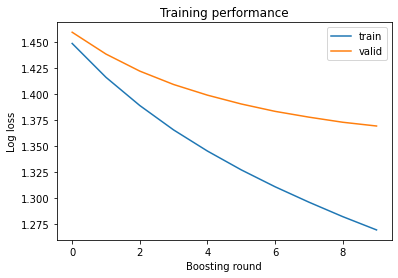

In [7]:
# learning process
plt.plot(evaluation_results['train']['multi_logloss'], label='train')
plt.plot(evaluation_results['valid']['multi_logloss'], label='valid')
plt.ylabel('Log loss')
plt.xlabel('Boosting round')
plt.title('Training performance')
plt.legend()
plt.savefig('cv_logloss.jpg')
plt.show()

### Importance feature

In [8]:
# show the importance features table
cols = list(X.columns)       # list of feautures
f_importance = np.array(model.feature_importance()) # importance feature
f_importance = f_importance / np.sum(f_importance)  
df_importance = pd.DataFrame({'feature':cols, 'importance':f_importance})
df_importance = df_importance.sort_values('importance', ascending=False) # sort
display(df_importance.head())

,feature,importance
28,NEWJobHunt,0.069333
18,JobSeek,0.041067
35,NEWPurchaseResearch,0.036000
6,ConvertedComp,0.034933
12,DevType,0.034400


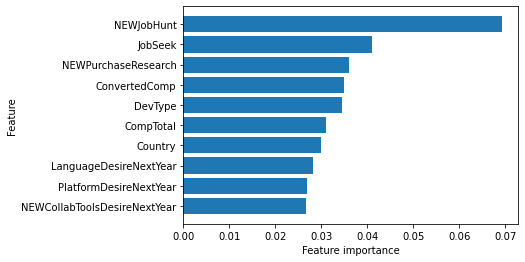

In [9]:
# show the importance features gragh
def plot_feature_importance(df): 
    n_features = len(df)                              
    df_plot = df.sort_values('importance')            
    f_importance_plot = df_plot['importance'].values  
    plt.barh(range(n_features), f_importance_plot, align='center') 
    cols_plot = df_plot['feature'].values            
    plt.yticks(np.arange(n_features), cols_plot)     
    plt.xlabel('Feature importance')                  
    plt.ylabel('Feature')                             

plot_feature_importance(df_importance[:10])

### Make the table that explain the influence between Job satisfaction and NEWJobHunt.

In [10]:
df_drop_NaN = df.dropna(subset=['NEWJobHunt'])
df_Just_because = df_drop_NaN[df_drop_NaN['NEWJobHunt'].str.contains('Just because')]
df_Having_a_bad_day = df_drop_NaN[df_drop_NaN['NEWJobHunt'].str.contains('Having a bad day')]
df_wider_networke = df_drop_NaN[df_drop_NaN['NEWJobHunt'].str.contains('wider network')]
df_Curious_about_other_opportunities = df_drop_NaN[df_drop_NaN['NEWJobHunt'].str.contains('Curious about other opportunities')]
df_Better_compensation = df_drop_NaN[df_drop_NaN['NEWJobHunt'].str.contains('Better compensation')]
df_Trouble_with_my_teammatesn = df_drop_NaN[df_drop_NaN['NEWJobHunt'].str.contains('Trouble with my teammates')]
df_Trouble_with_my_direct_manager = df_drop_NaN[df_drop_NaN['NEWJobHunt'].str.contains('Trouble with my direct manager')]
df_Trouble_with_leadership_at_my_company = df_drop_NaN[df_drop_NaN['NEWJobHunt'].str.contains('Trouble with leadership at my company')]
df_Better_work_life_balance = df_drop_NaN[df_drop_NaN['NEWJobHunt'].str.contains('Better work/life balance')]
df_Wanting_to_work_with_new_technologies = df_drop_NaN[df_drop_NaN['NEWJobHunt'].str.contains('Wanting to work with new technologies')]
df_Growth_or_leadership_opportunities = df_drop_NaN[df_drop_NaN['NEWJobHunt'].str.contains('Growth or leadership opportunities')]
df_Looking_to_relocate = df_drop_NaN[df_drop_NaN['NEWJobHunt'].str.contains('Looking to relocate')]

In [11]:
df_list =[df_Just_because, df_Having_a_bad_day,df_wider_networke, df_Curious_about_other_opportunities, df_Better_compensation, df_Trouble_with_my_teammatesn, \
          df_Trouble_with_my_direct_manager, df_Trouble_with_leadership_at_my_company, df_Better_work_life_balance, \
          df_Wanting_to_work_with_new_technologies, df_Growth_or_leadership_opportunities, df_Looking_to_relocate] 

index_list = ["Just because", "Having a bad day (or week or month) at work", "Wanting to share accomplishments with a wider network", \
            "Curious about other opportunities", "Better compensation", "Trouble with my teammates", "Trouble with my direct manager", \
            "Trouble with leadership at my company", "Better work/life balance", "Wanting to work with new technologies", \
            "Growth or leadership opportunities", "Looking to relocate"]

In [12]:
# Make the table
def sort_df(df):
    table = { key: (df['JobSat']==key).sum() for key in set(df['JobSat'])} 
    values = [table["Very satisfied"], table["Slightly satisfied"], table["Neither satisfied nor dissatisfied"], table["Slightly dissatisfied"], table["Very dissatisfied"]]/(table["Very satisfied"] + table["Slightly satisfied"] + table["Neither satisfied nor dissatisfied"] + table["Slightly dissatisfied"] + table["Very dissatisfied"])
    label = ["Very satisfied", "Slightly satisfied", "Neither satisfied nor dissatisfied", "Slightly dissatisfied", "Very dissatisfied"]
    
    return pd.Series(values, index = label)

df_summary = pd.DataFrame({"Very satisfied":[]})
for i in df_list:
    df_temp = sort_df(i)
    df_summary = df_summary.append(df_temp, ignore_index=True, sort=True)
    
df_summary.index = index_list
df_summary

,Neither satisfied nor dissatisfied,Slightly dissatisfied,Slightly satisfied,Very dissatisfied,Very satisfied
Just because,0.133375,0.140177,0.340136,0.065141,0.321171
Having a bad day (or week or month) at work,0.144463,0.239416,0.325401,0.089213,0.201507
Wanting to share accomplishments with a wider network,0.164824,0.194547,0.320806,0.086711,0.233112
Curious about other opportunities,0.125373,0.163391,0.334644,0.069123,0.307470
Better compensation,0.131690,0.169531,0.328014,0.076629,0.294136
Trouble with my teammates,0.116891,0.159646,0.282856,0.098568,0.342039
Trouble with my direct manager,0.109244,0.163431,0.274993,0.110258,0.342075
Trouble with leadership at my company,0.114539,0.200146,0.281008,0.106872,0.297435
Better work/life balance,0.143013,0.164620,0.316597,0.083113,0.292658
Wanting to work with new technologies,0.134688,0.174522,0.321766,0.078140,0.290884
